In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from pathlib import Path
import torch
from sklearn import metrics
from torchvision import models
from torchvision.models import MobileNet_V3_Small_Weights
from torch import nn
from model_utils import eval_per_class


## Custom Functions

In [ ]:
def csv_dirs(data_folder:str)->list:
    dirs = glob.glob(f"{Path(data_folder)/'**'}", recursive=True)
    csv_dirs = []
    for path in dirs:
        if ".csv" in path:
            csv_dirs.append(path)
    return csv_dirs


def plot_dataframe_old(df: pd.DataFrame, title: str = ""):
    epochs = df["Epoch"]
    acc = df["Accuracy"]
    loss = df["Average_loss"]
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.title(title, fontsize=20, pad=20, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc)
    ymin, ymax = acc.min(), acc.max()
    plt.yticks(np.linspace(ymin, ymax, 7))
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Average_loss")
    plt.plot(epochs, loss, color="r", ls="--")
    ymin, ymax = loss.min(), loss.max()
    plt.yticks(np.linspace(ymin, ymax, 7))
    plt.grid()
    plt.tight_layout()
    plt.show()


def plot_dataframe(df: pd.DataFrame, title: str = ""):
    epochs = df["Epoch"]
    cols = df.columns.to_list()
    if not "Training_accuracy" in cols:
        plot_dataframe_old(df, title)
        return
    train_acc = df["Training_accuracy"]
    train_loss = df["Training_loss"]
    val_acc = df["Validation_accuracy"]
    val_loss = df["Validation_loss"]
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.title(title, fontsize=20,pad=20, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, train_acc, label='training accuracy')
    plt.plot(epochs, val_acc, color="g", ls=":", label="validation accuracy")
    plt.legend()
    amin, amax = train_acc.min(), train_acc.max()
    lmin, lmax = val_acc.min(), val_acc.max()
    plt.yticks(np.linspace(min(amin,lmin), max(amax,lmax), 7))
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Average_loss")
    plt.plot(epochs, train_loss, color="r", ls="--", label="training loss")
    plt.plot(epochs, val_loss, color="tab:orange", ls=":", label='validation loss')
    amin, amax = train_loss.min(), train_loss.max()
    lmin, lmax = val_loss.min(), val_loss.max()
    plt.legend()
    plt.yticks(np.linspace(min(amin, lmin), max(amax, lmax), 7))
    plt.grid()
    plt.tight_layout()
    plt.show()


def label_to_class(values:list[torch.Tensor], labels_map:dict)->list:
    new_values = []
    for v in values:
        new_v = labels_map[v.item()]
        new_values.append(new_v)
    return new_values

def confusion_matrix(title:str, true_values:list, pred_values:list, classes:list):
    cifar_confusion_matrix = metrics.confusion_matrix(
        true_values, pred_values, normalize=None
    )
    cifar_cm_disp = metrics.ConfusionMatrixDisplay(
        cifar_confusion_matrix, display_labels=classes
    )
    cifar_cm_disp.plot()
    plt.title(title)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

def get_batch_size(file_name:str):
    tokens = file_name.split('_')
    batch_size = tokens[3].split(':')[1]
    return int(batch_size)

def perform_eval(model_path:str, classes:list, data_loader):
    from mobilenet_wheat import MODEL
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
    labels_map = {i:clss for i, clss in enumerate(classes, 0)}

    model.classifier[2] = nn.Dropout(p=0.5, inplace=True)
    model.classifier[3] = nn.Linear(in_features=1024, out_features=len(classes))
    model.classifier.insert(0, nn.Dropout(p=0.3, inplace=True))

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    true_values, predicted_values = eval_per_class(data_loader, model, classes)
    true_values = label_to_class(true_values, labels_map)
    predicted_values = label_to_class(predicted_values, labels_map)
    return true_values, predicted_values

## Accuracy and Loss curves over epochs

### CIFAR10

In [ ]:

data_folder = 'output_data/mobilenet_cifar_unfrozen'
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip('.csv')
    df = pd.read_csv(f)
    plot_dataframe(df, title)

### Wheat data

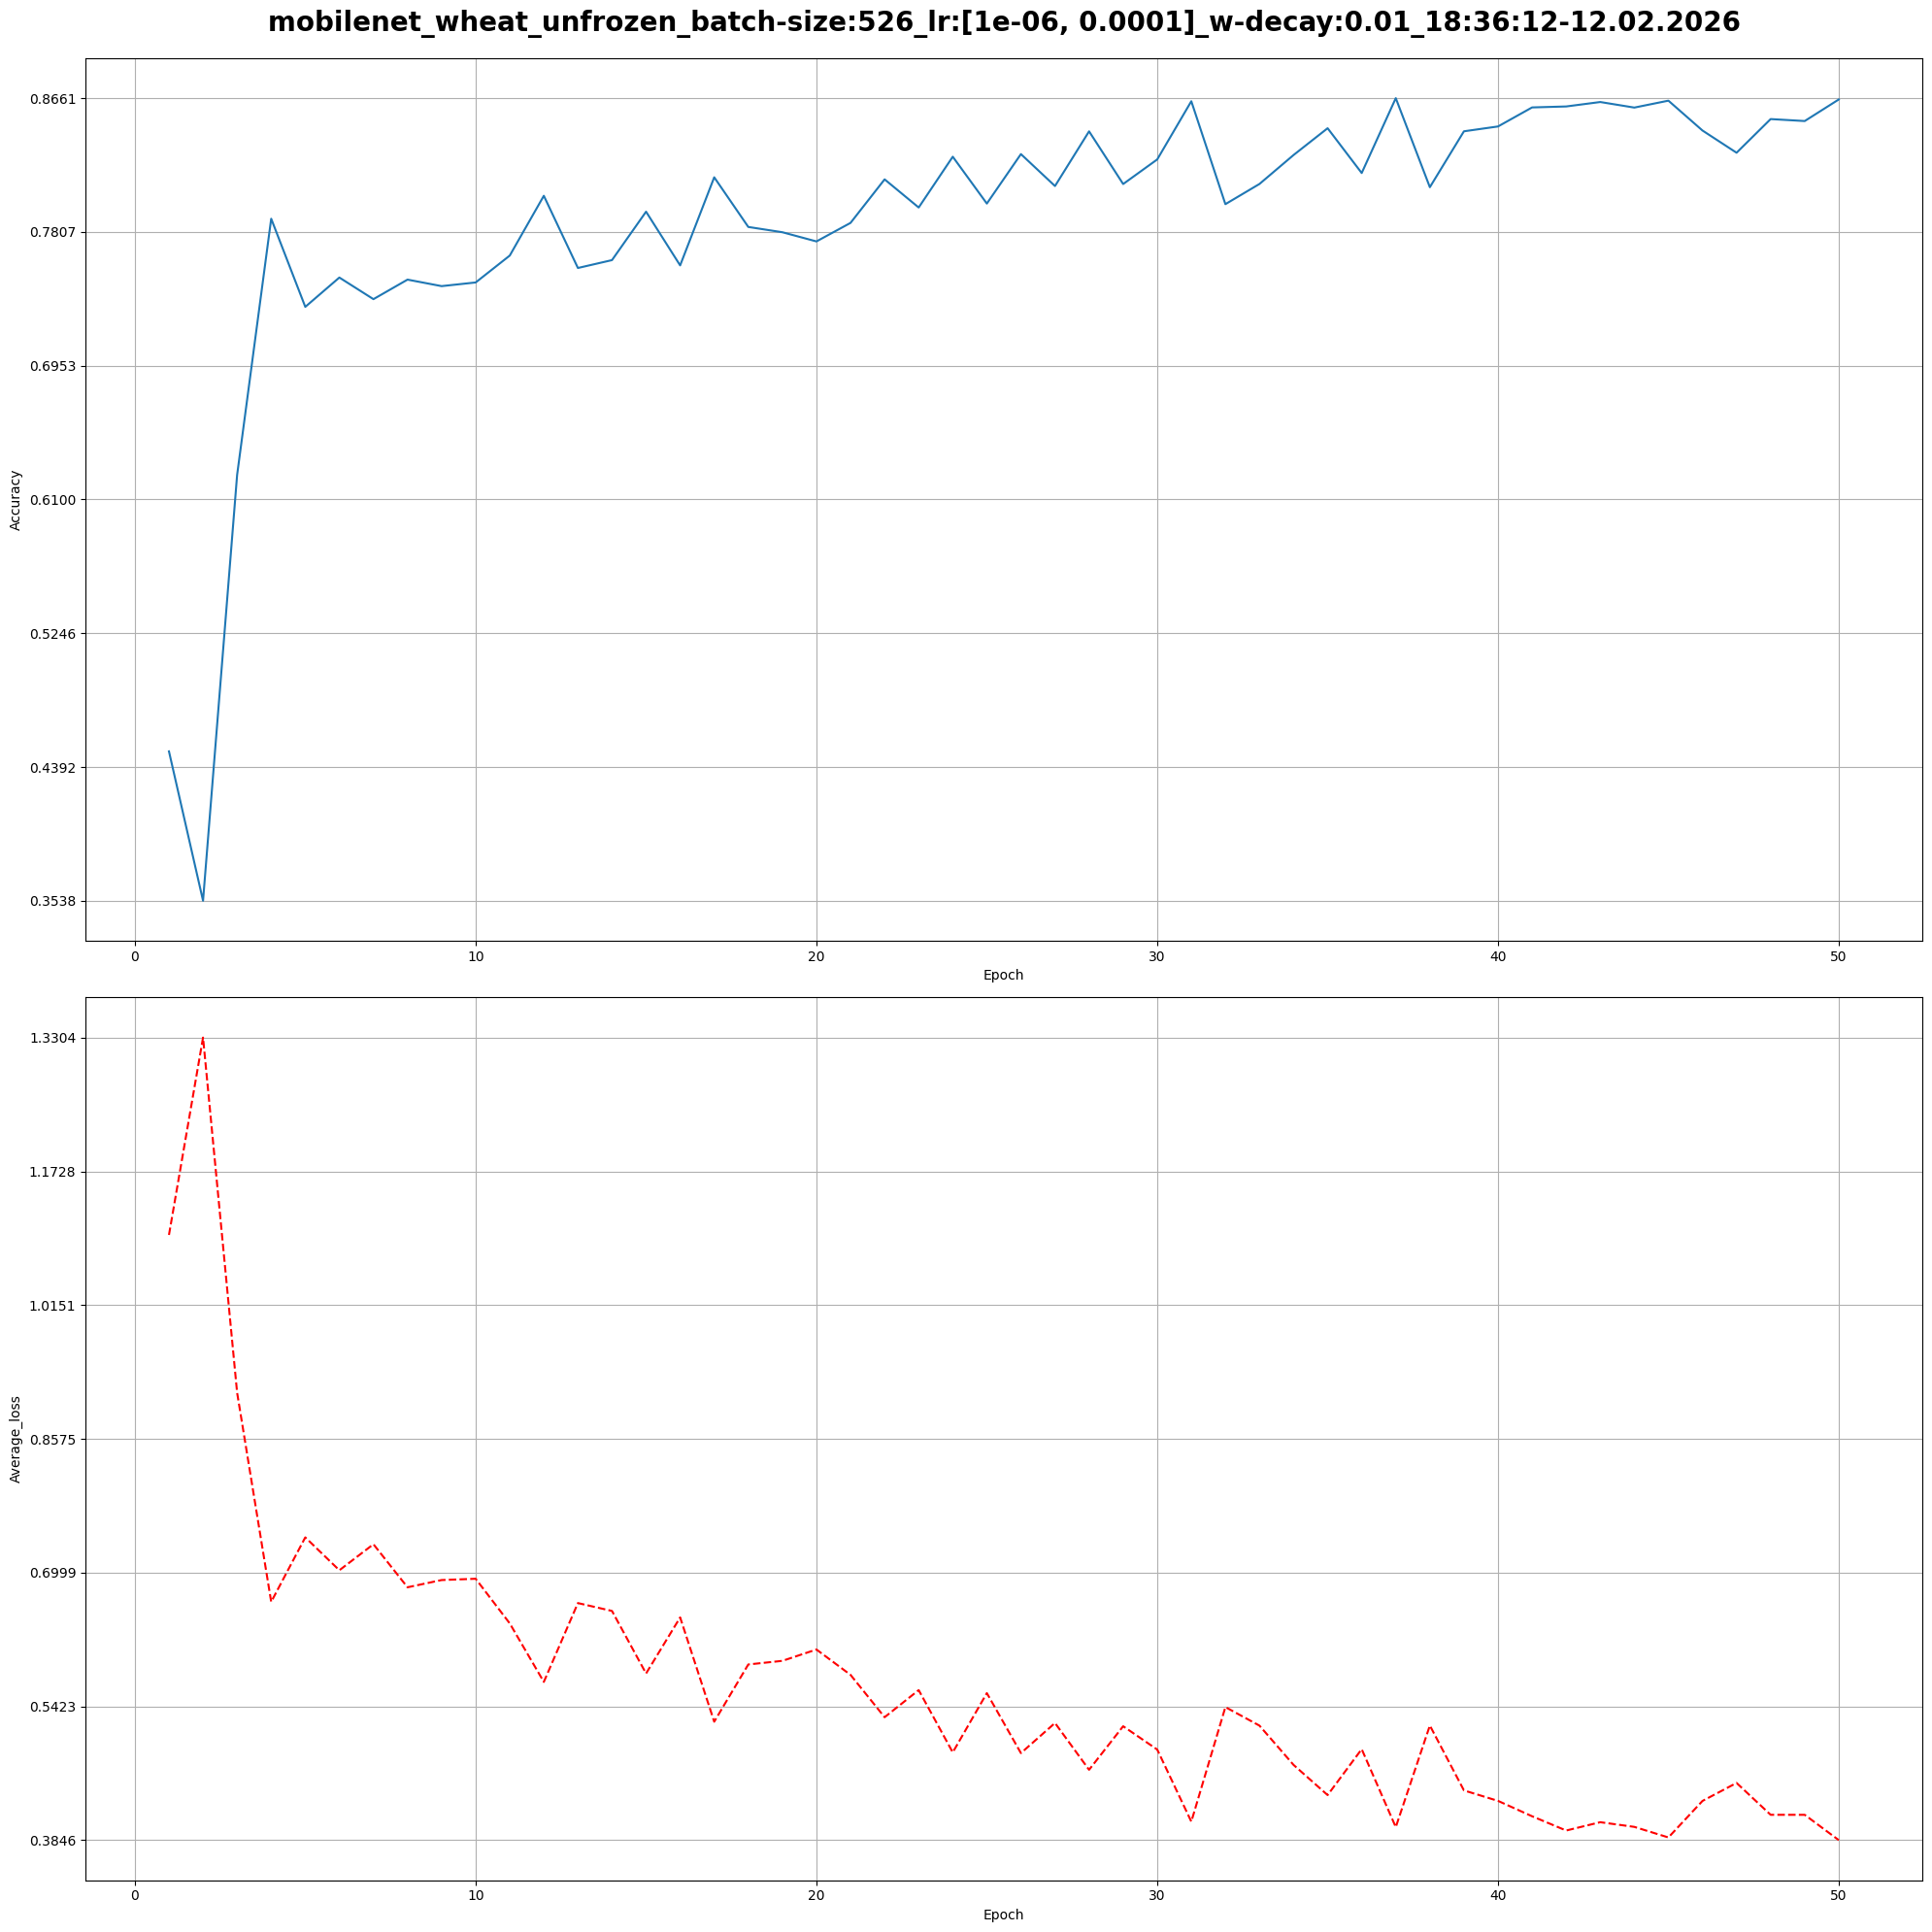

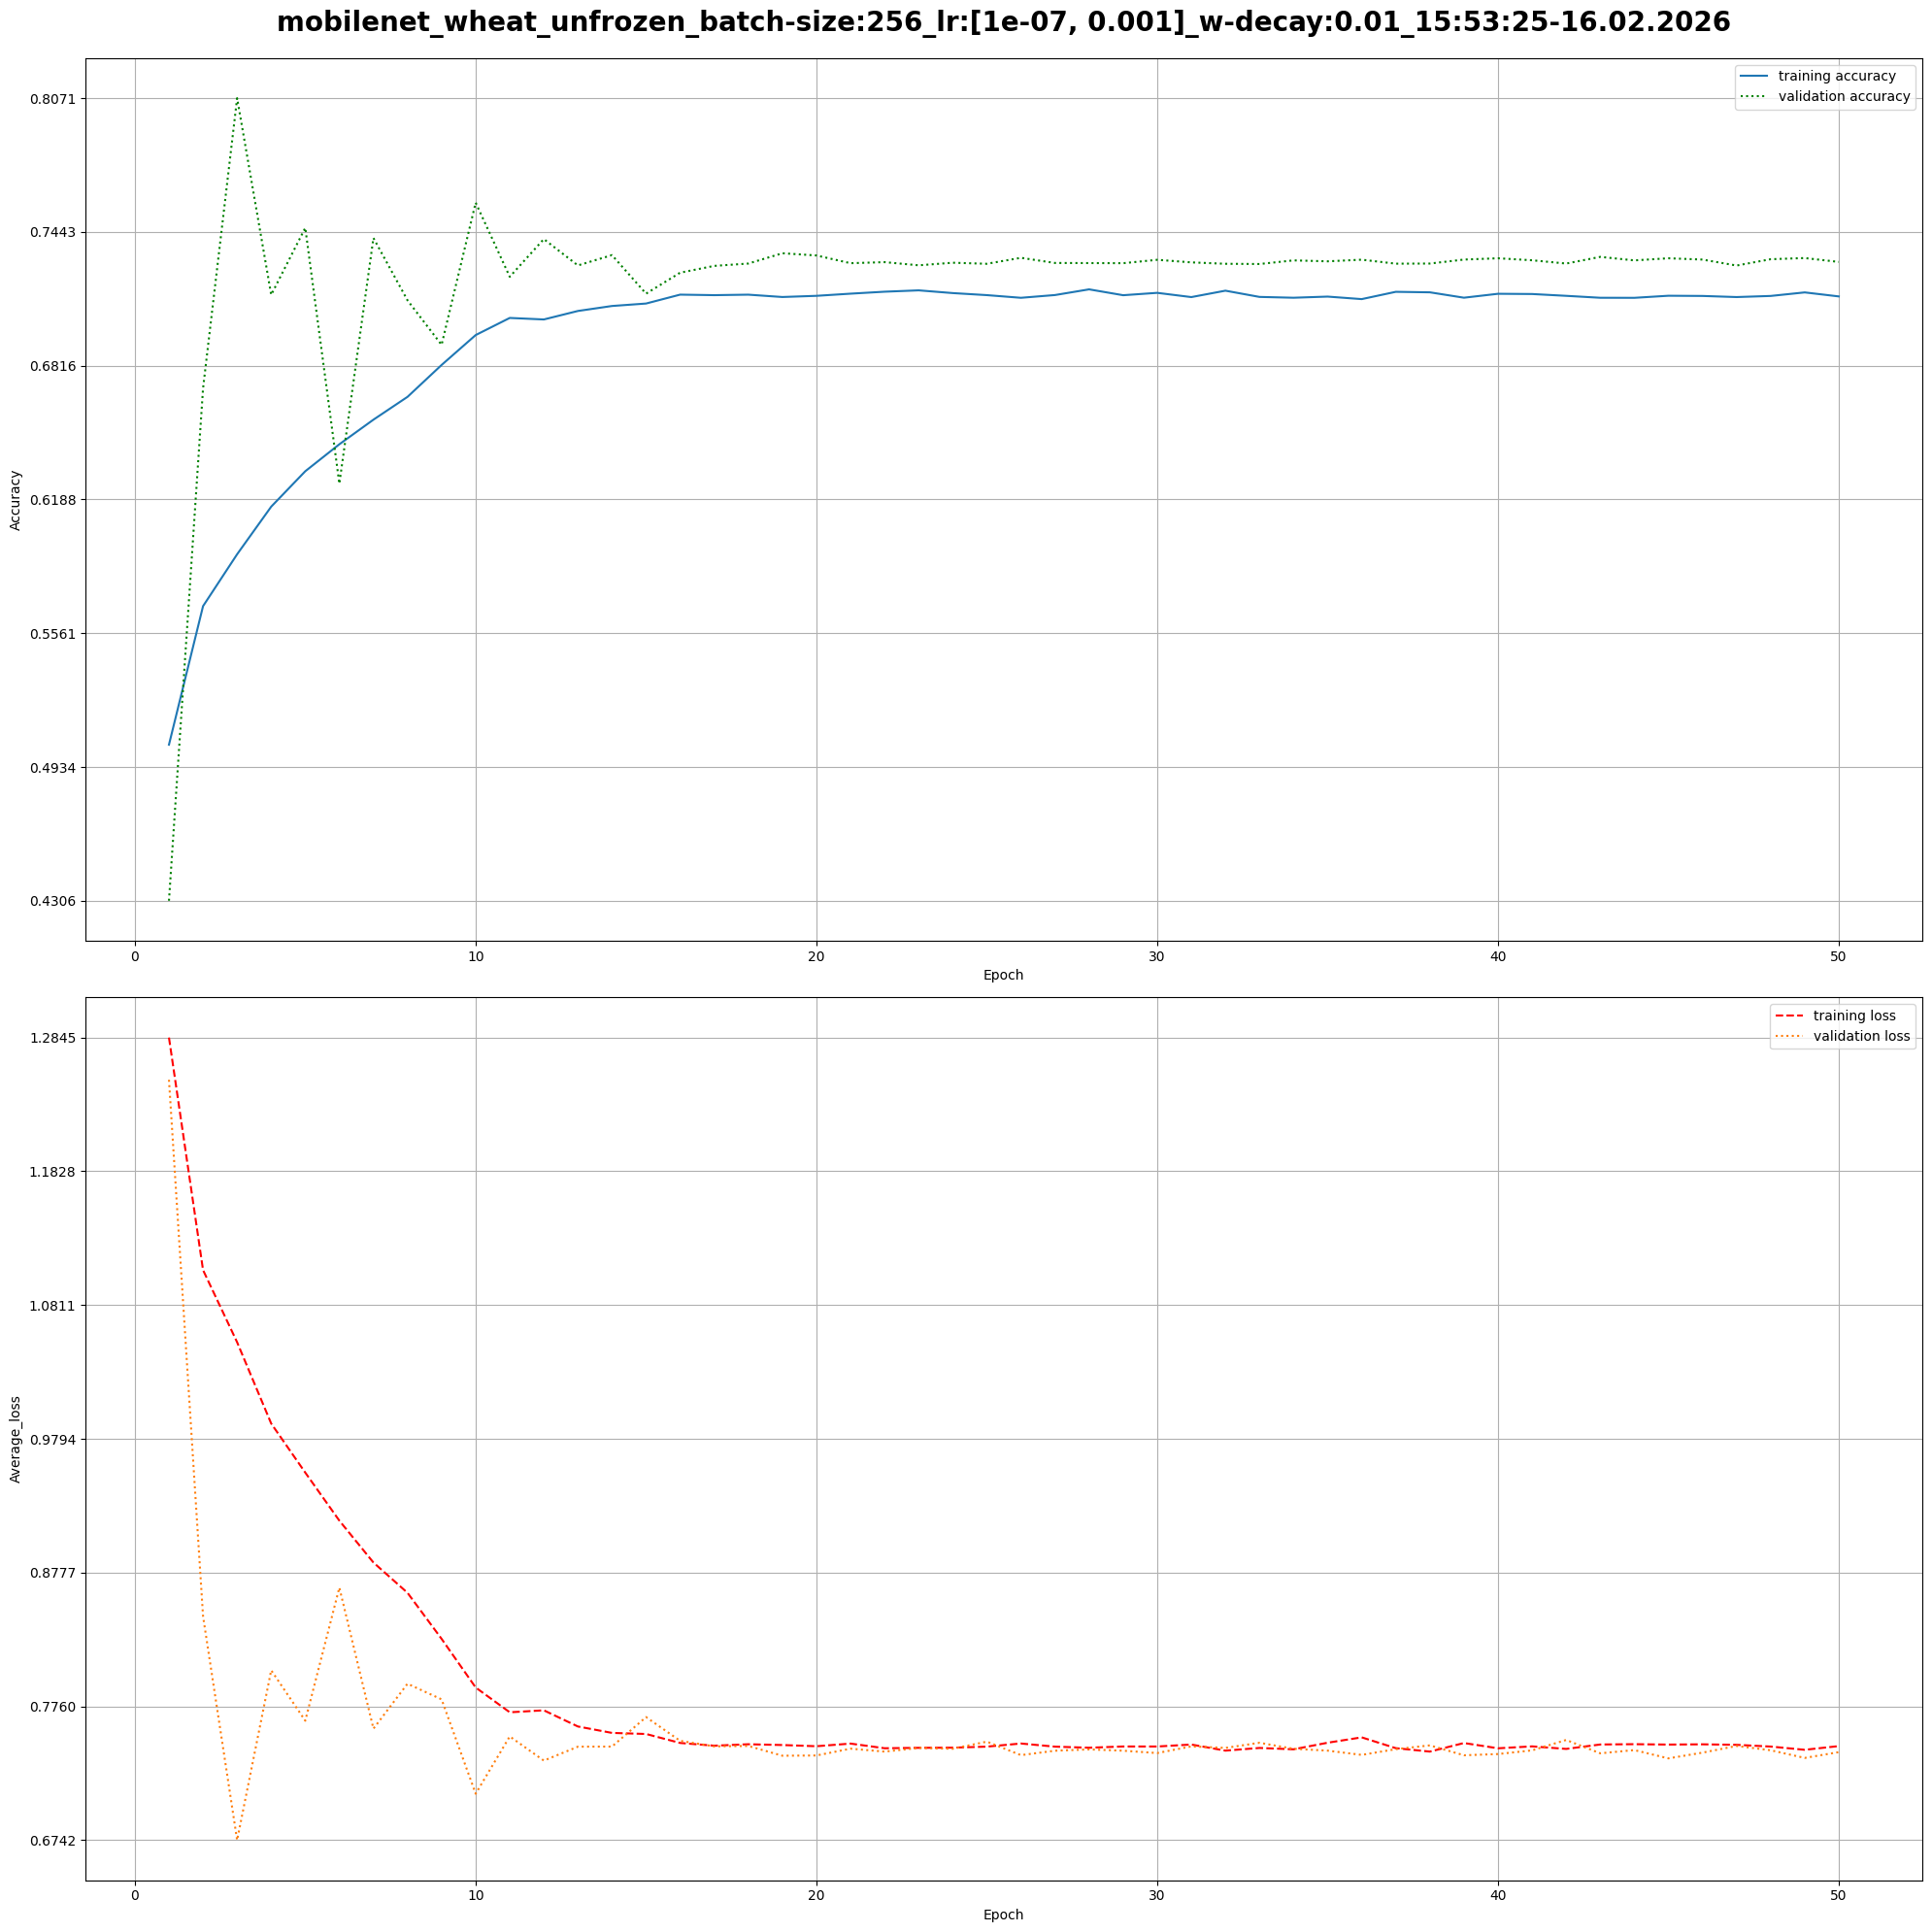

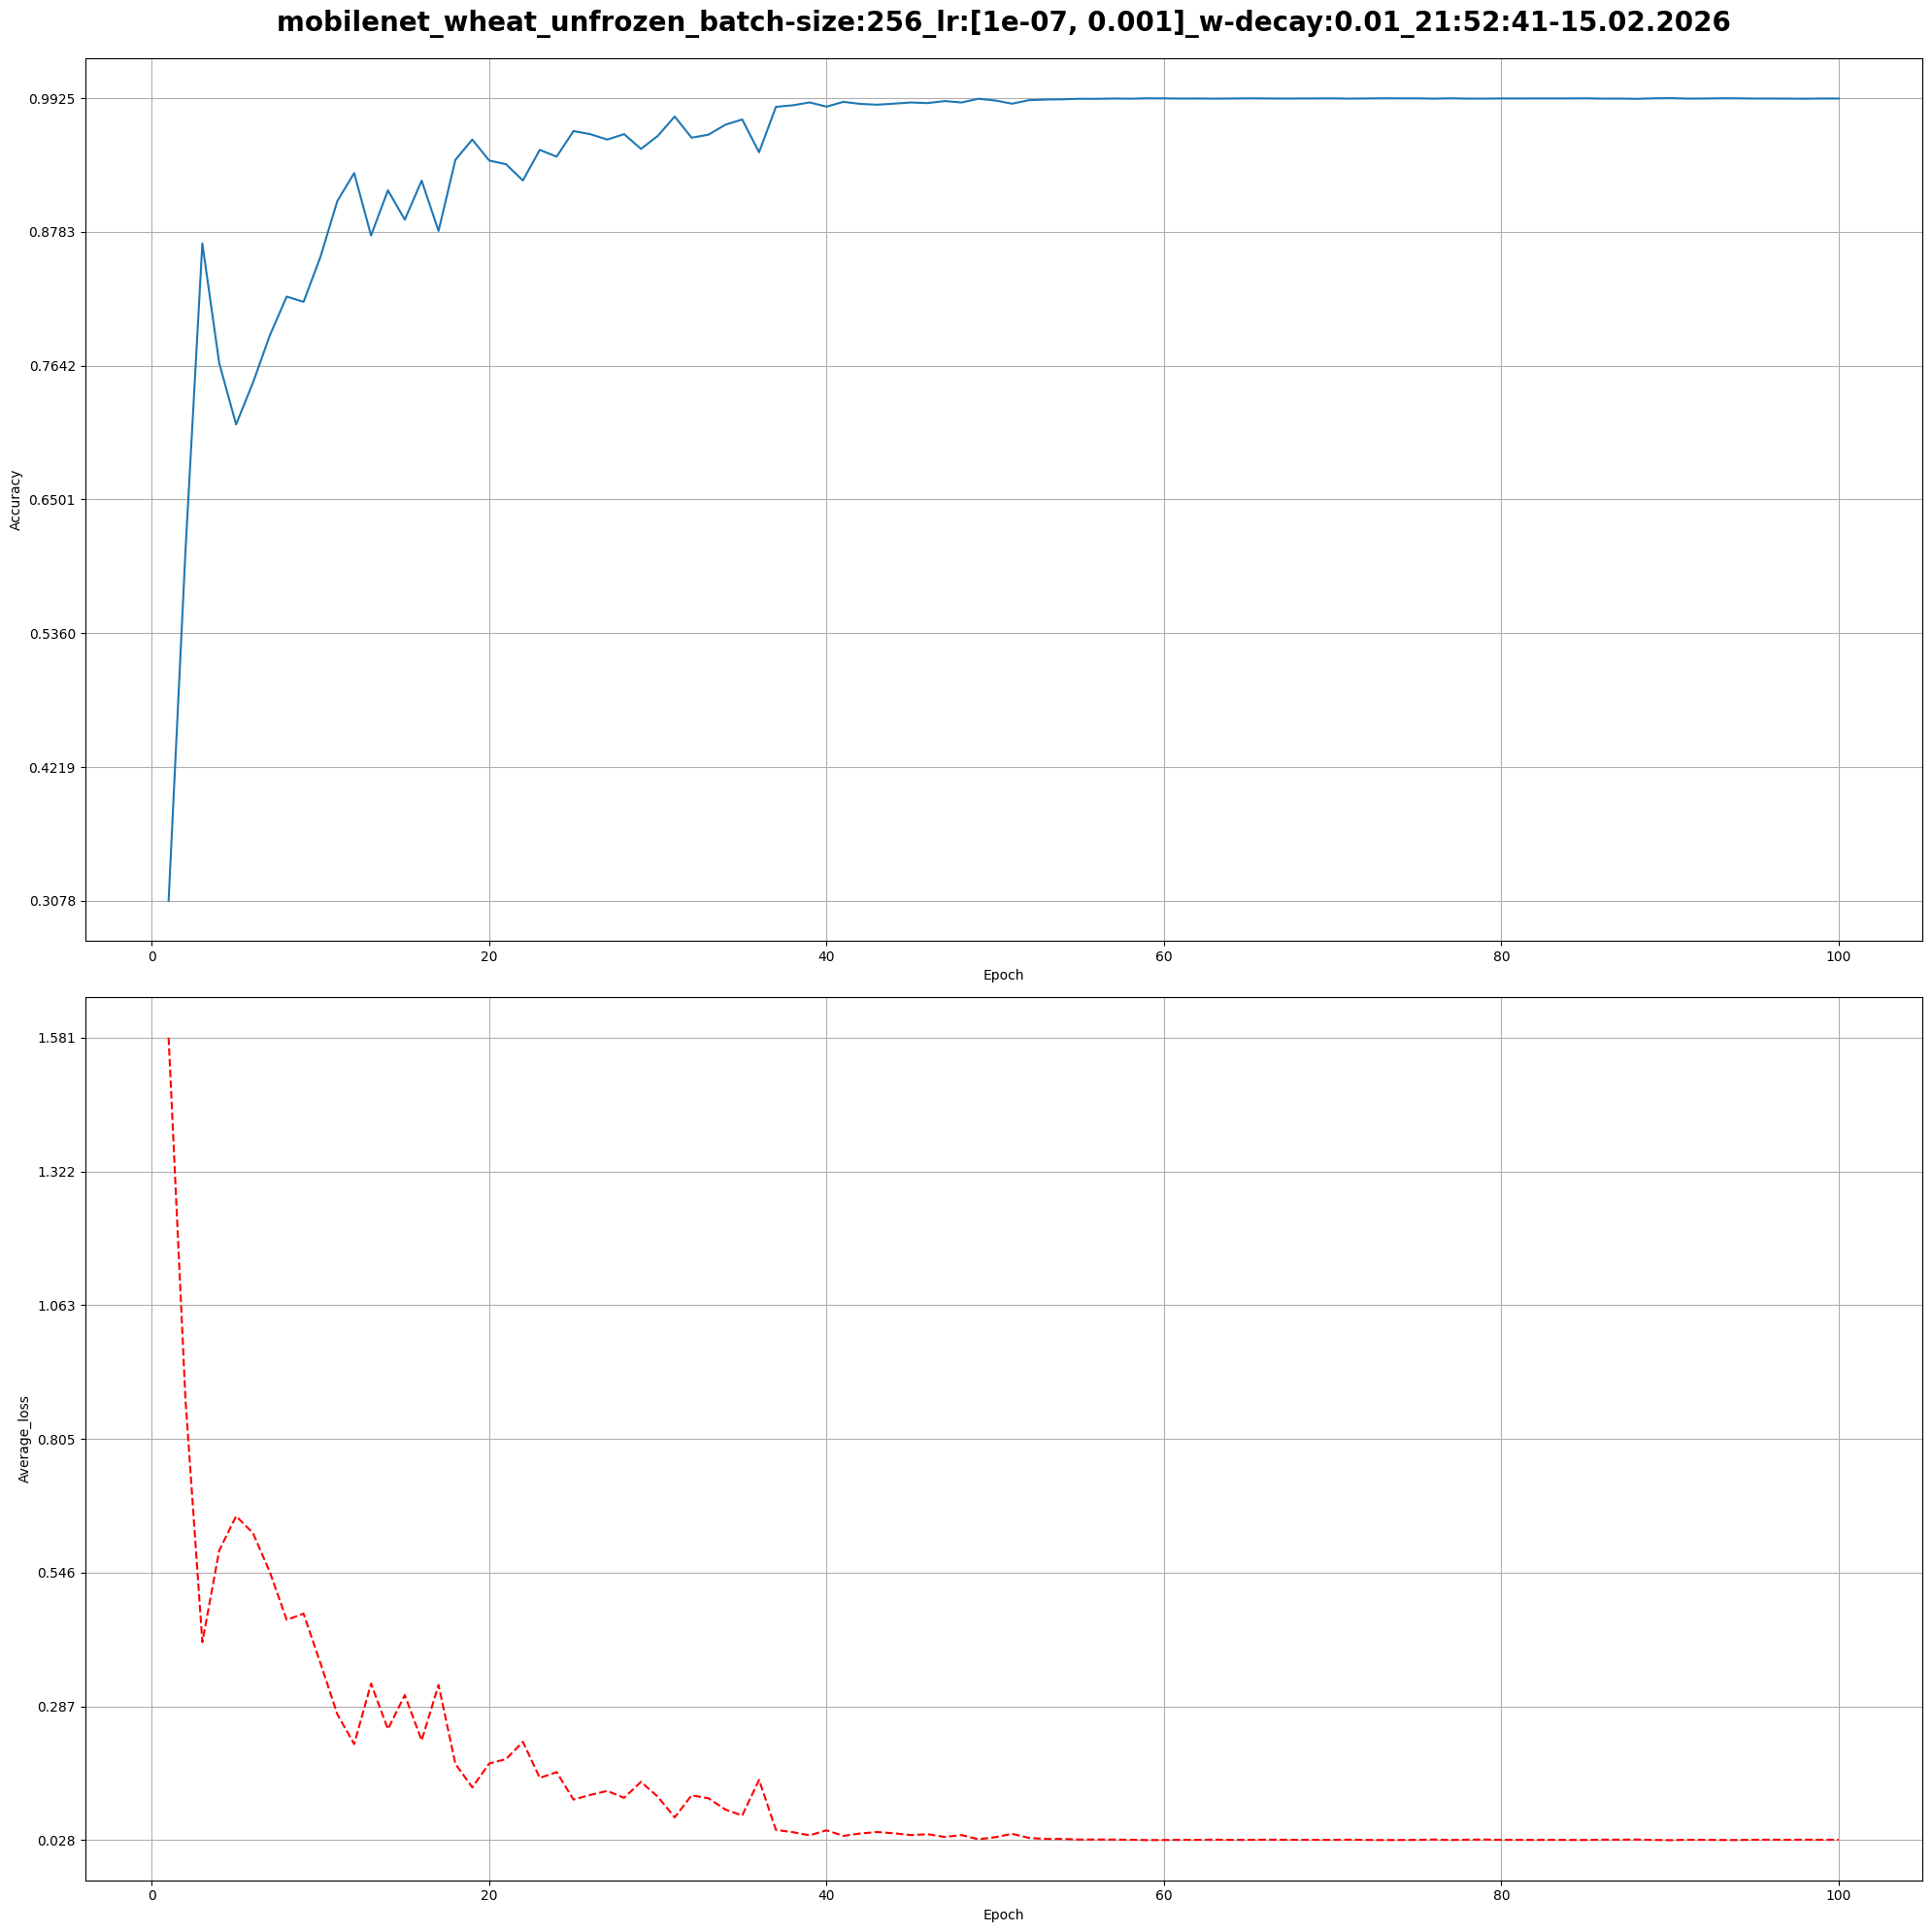

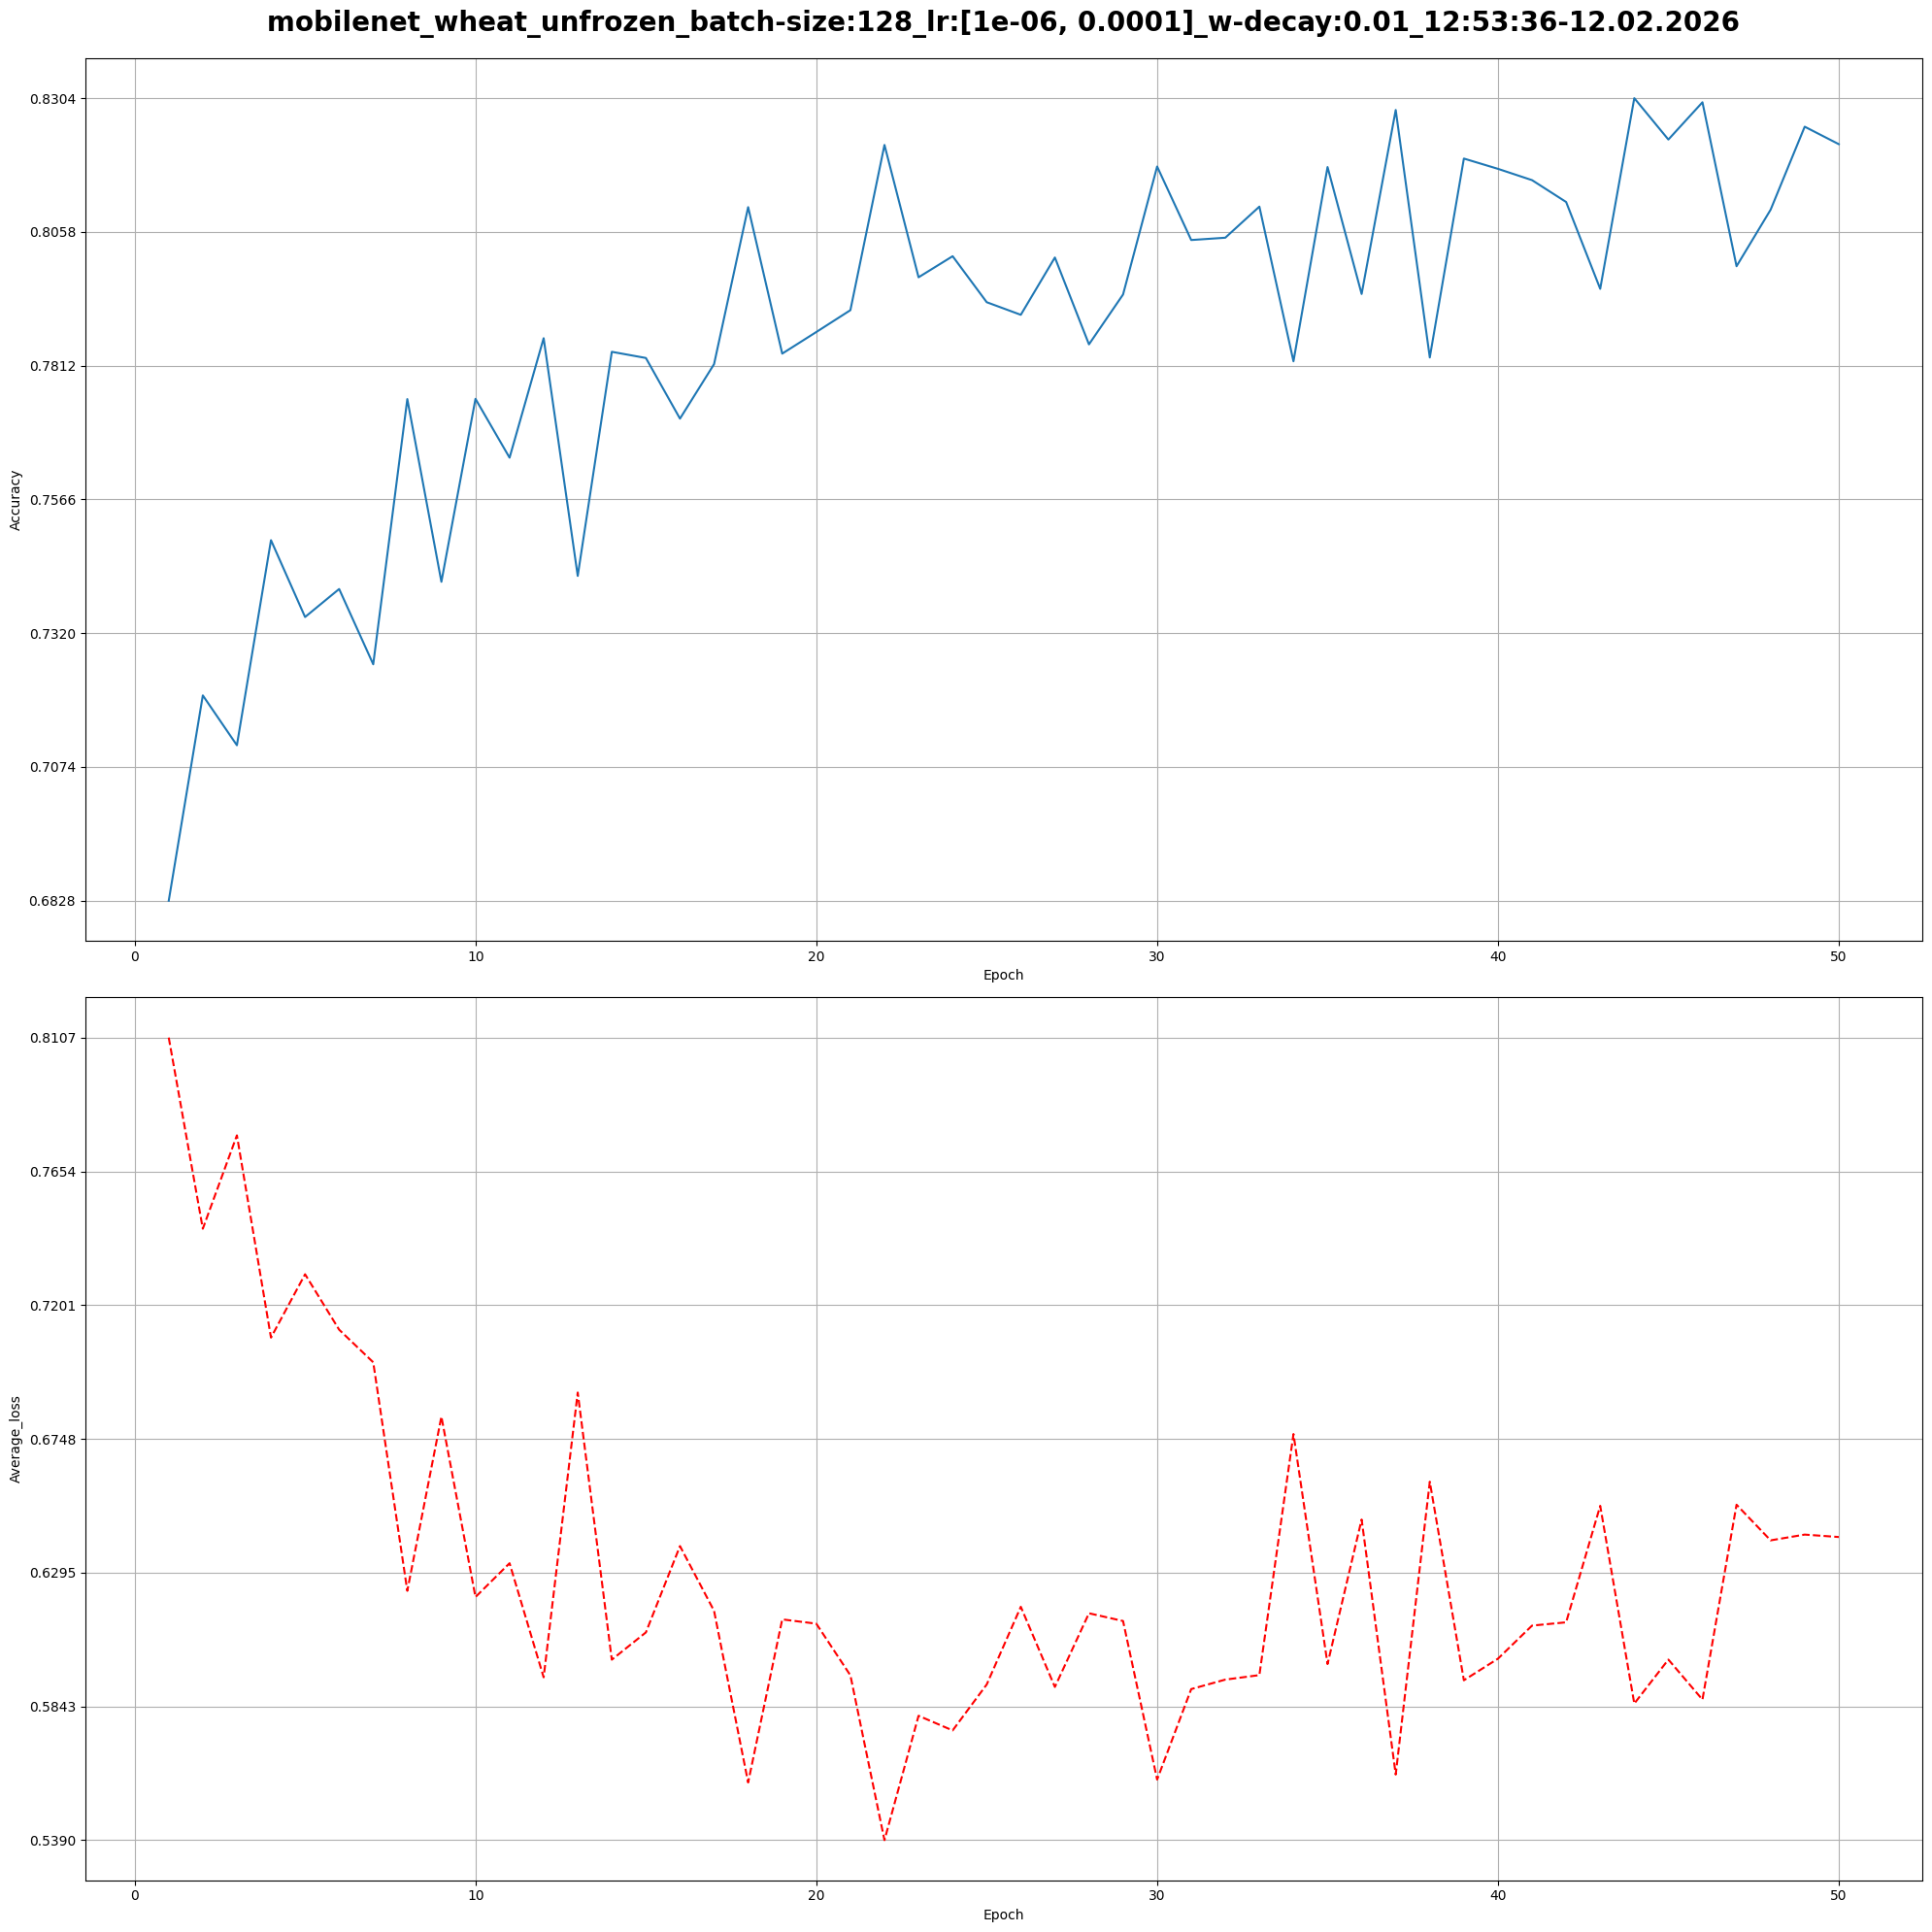

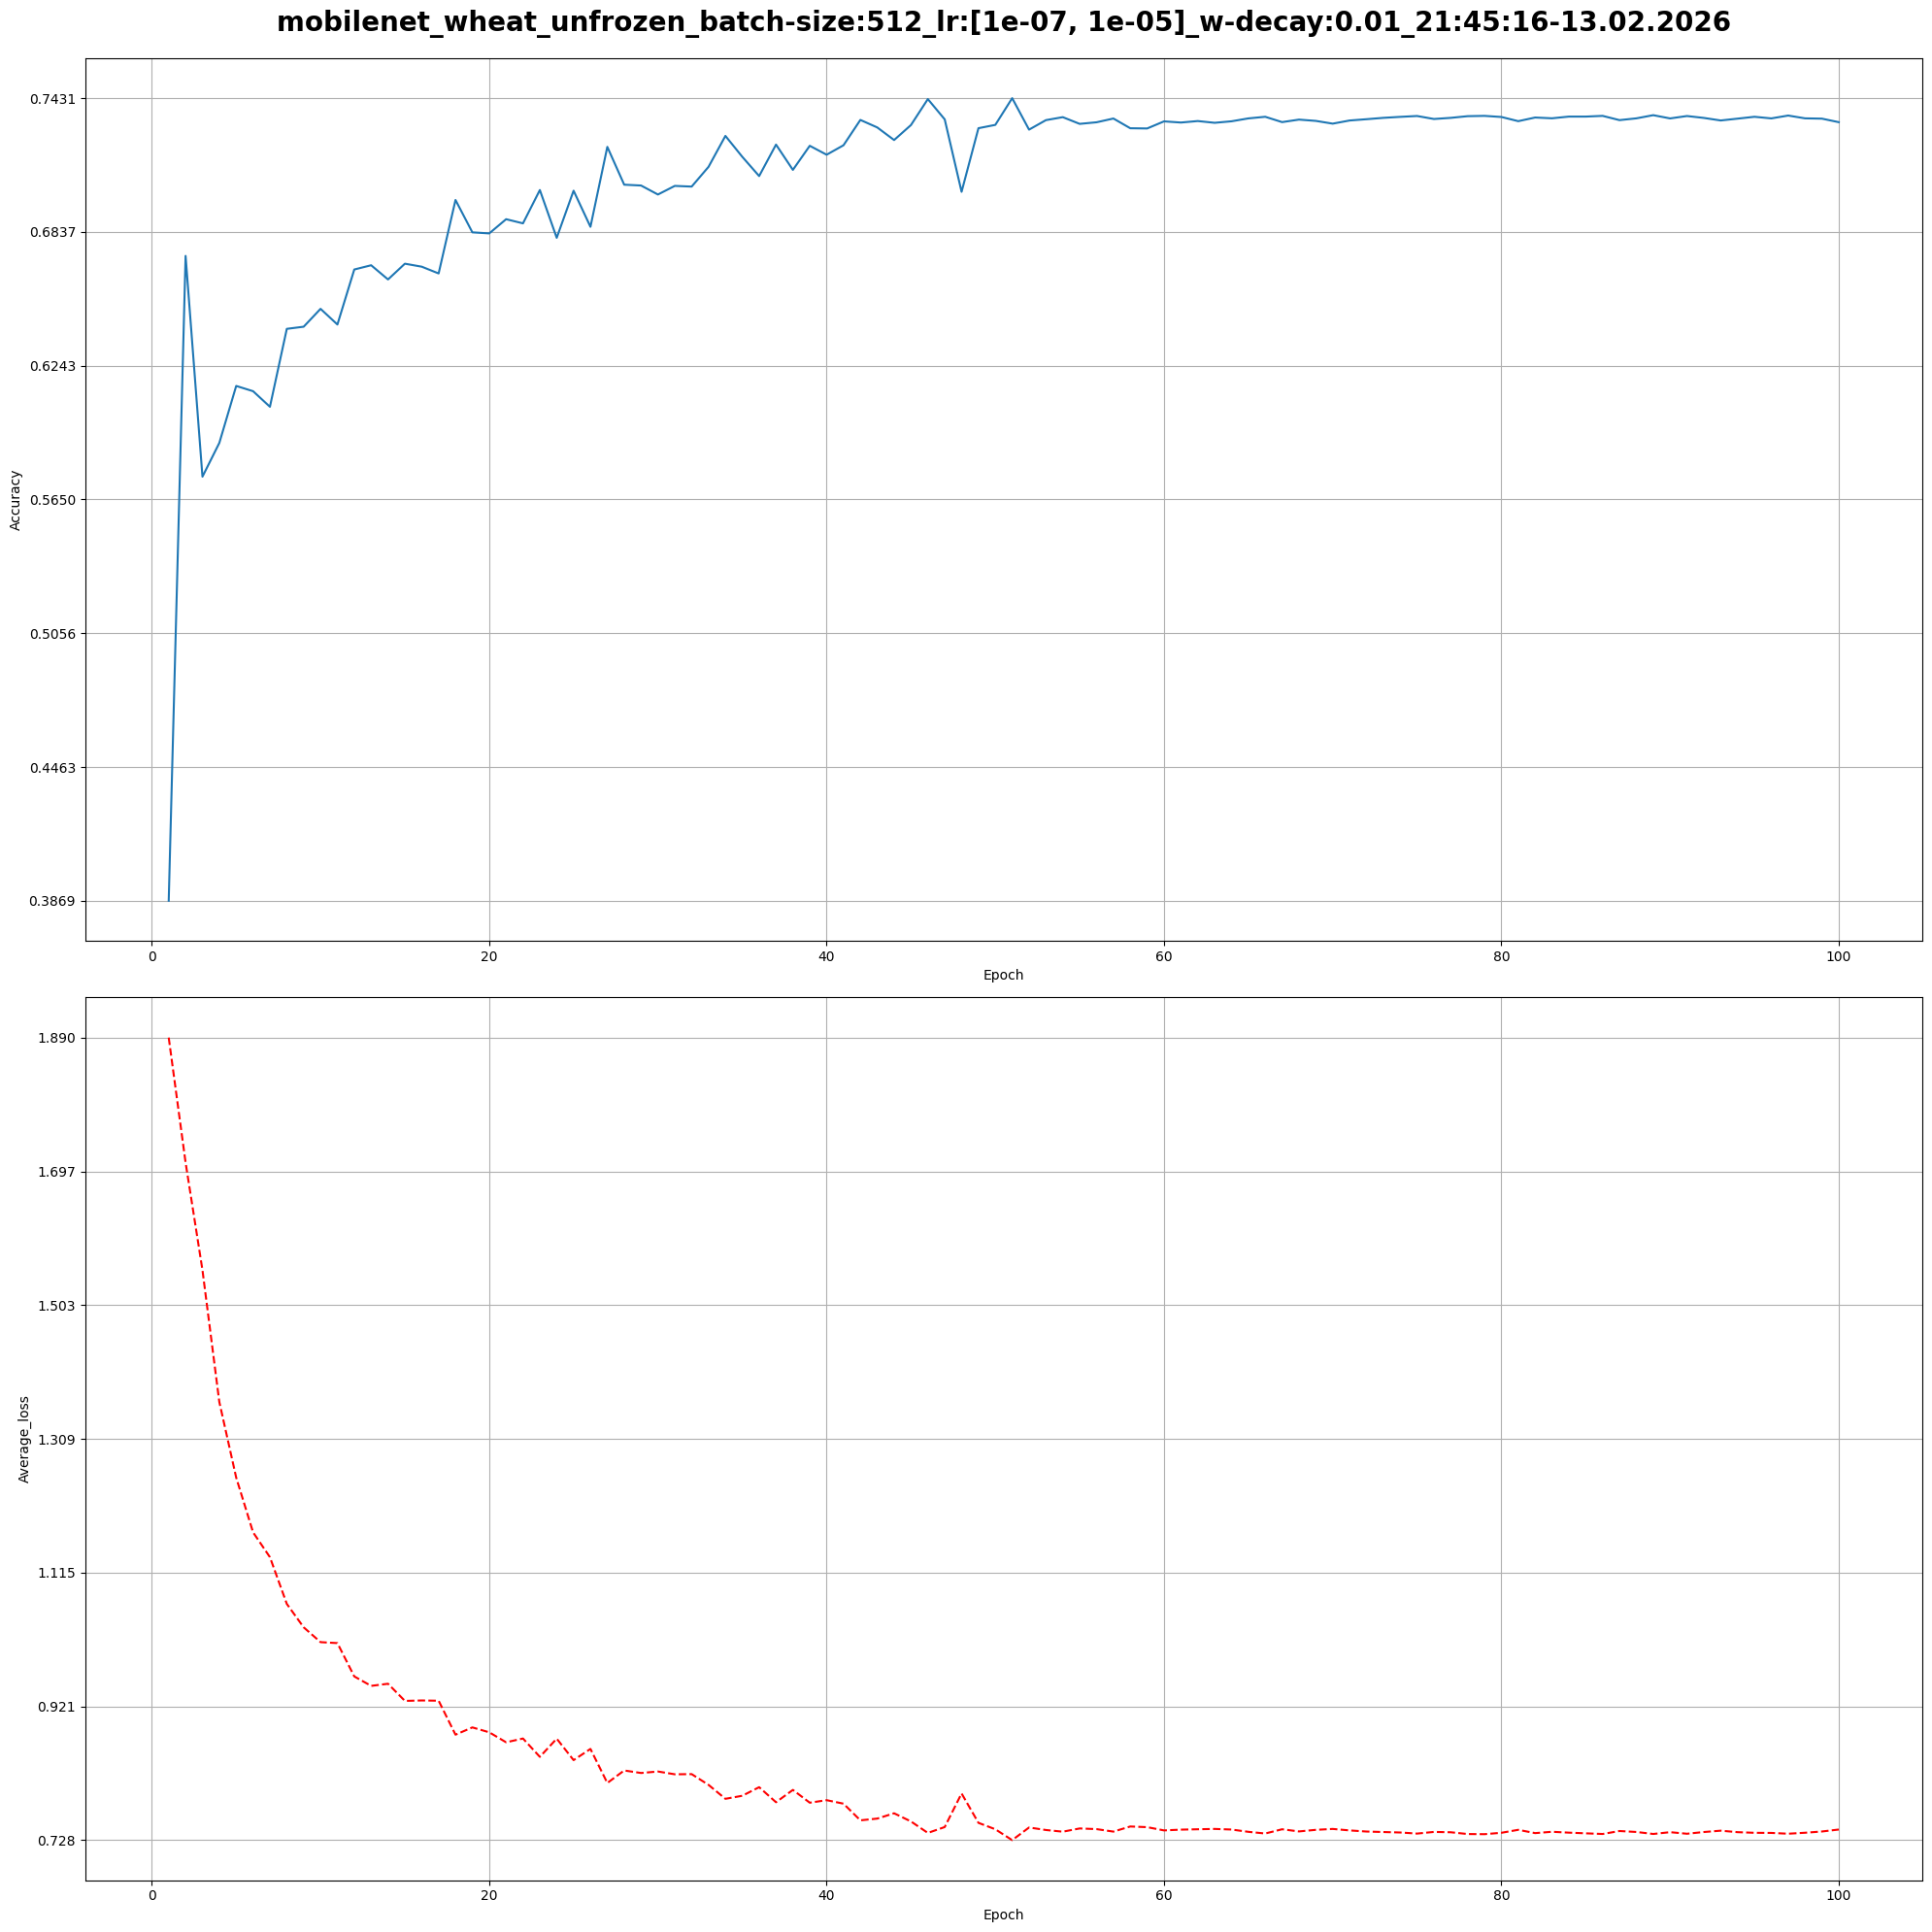

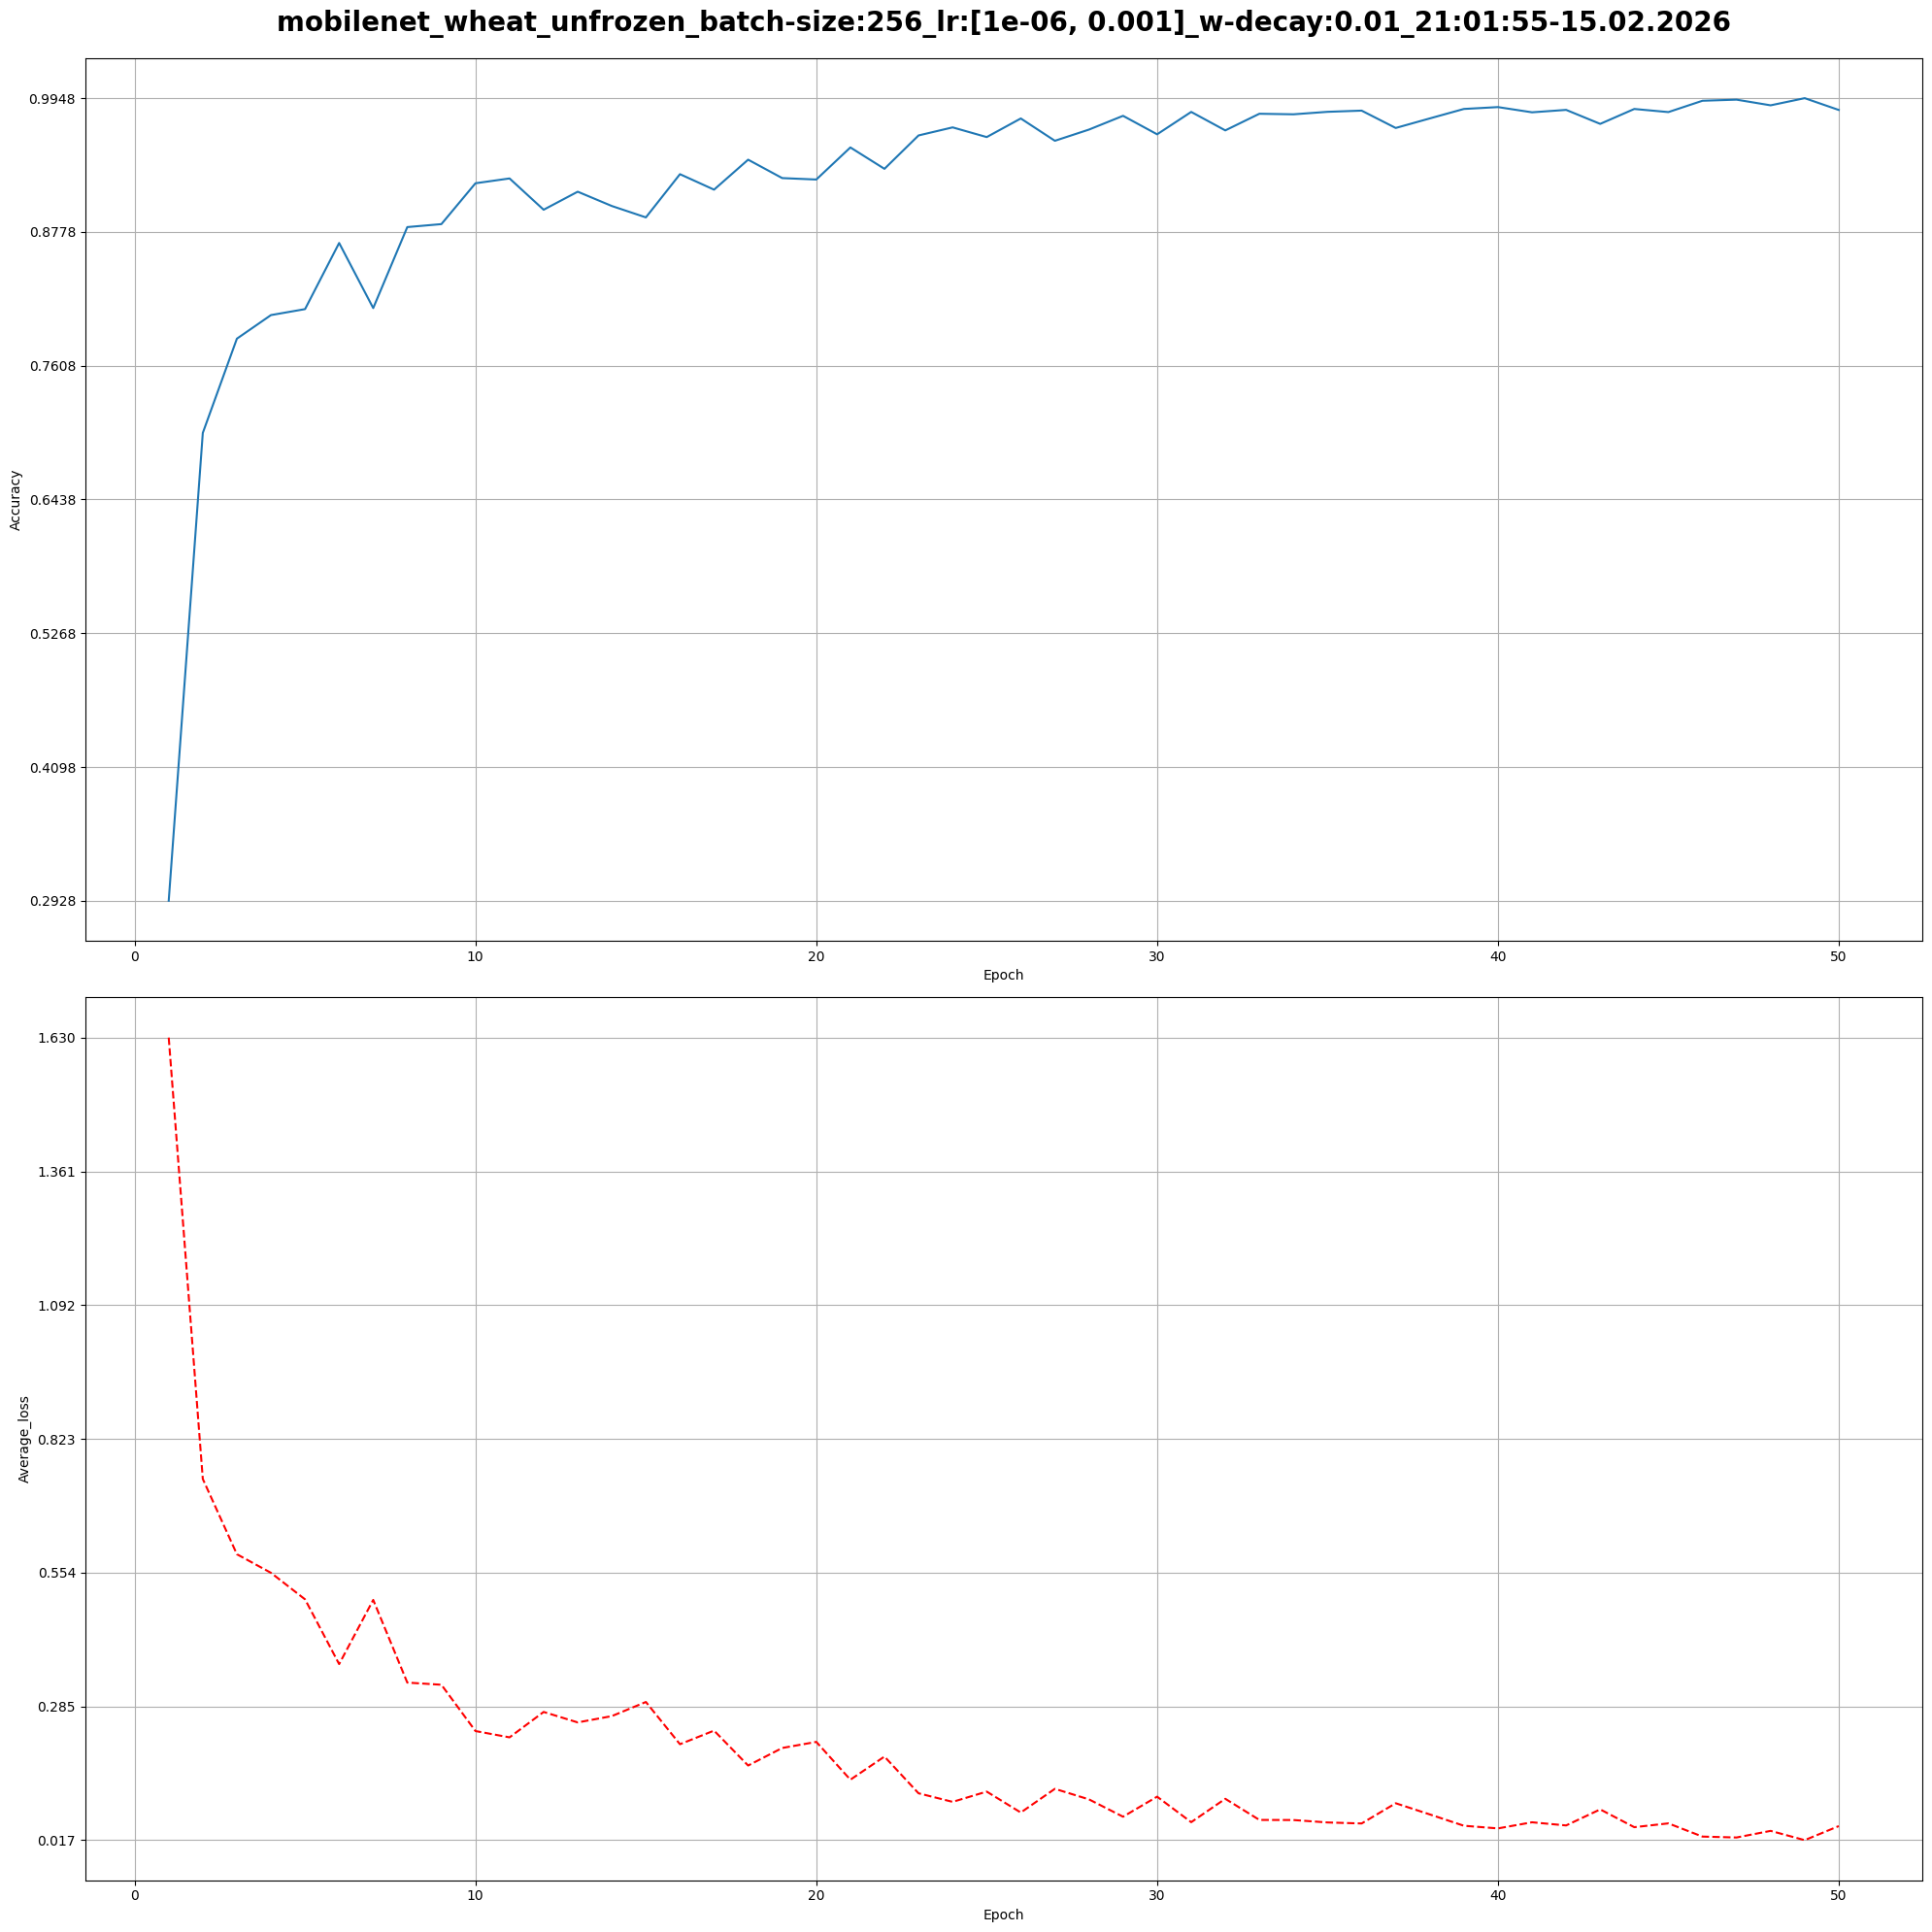

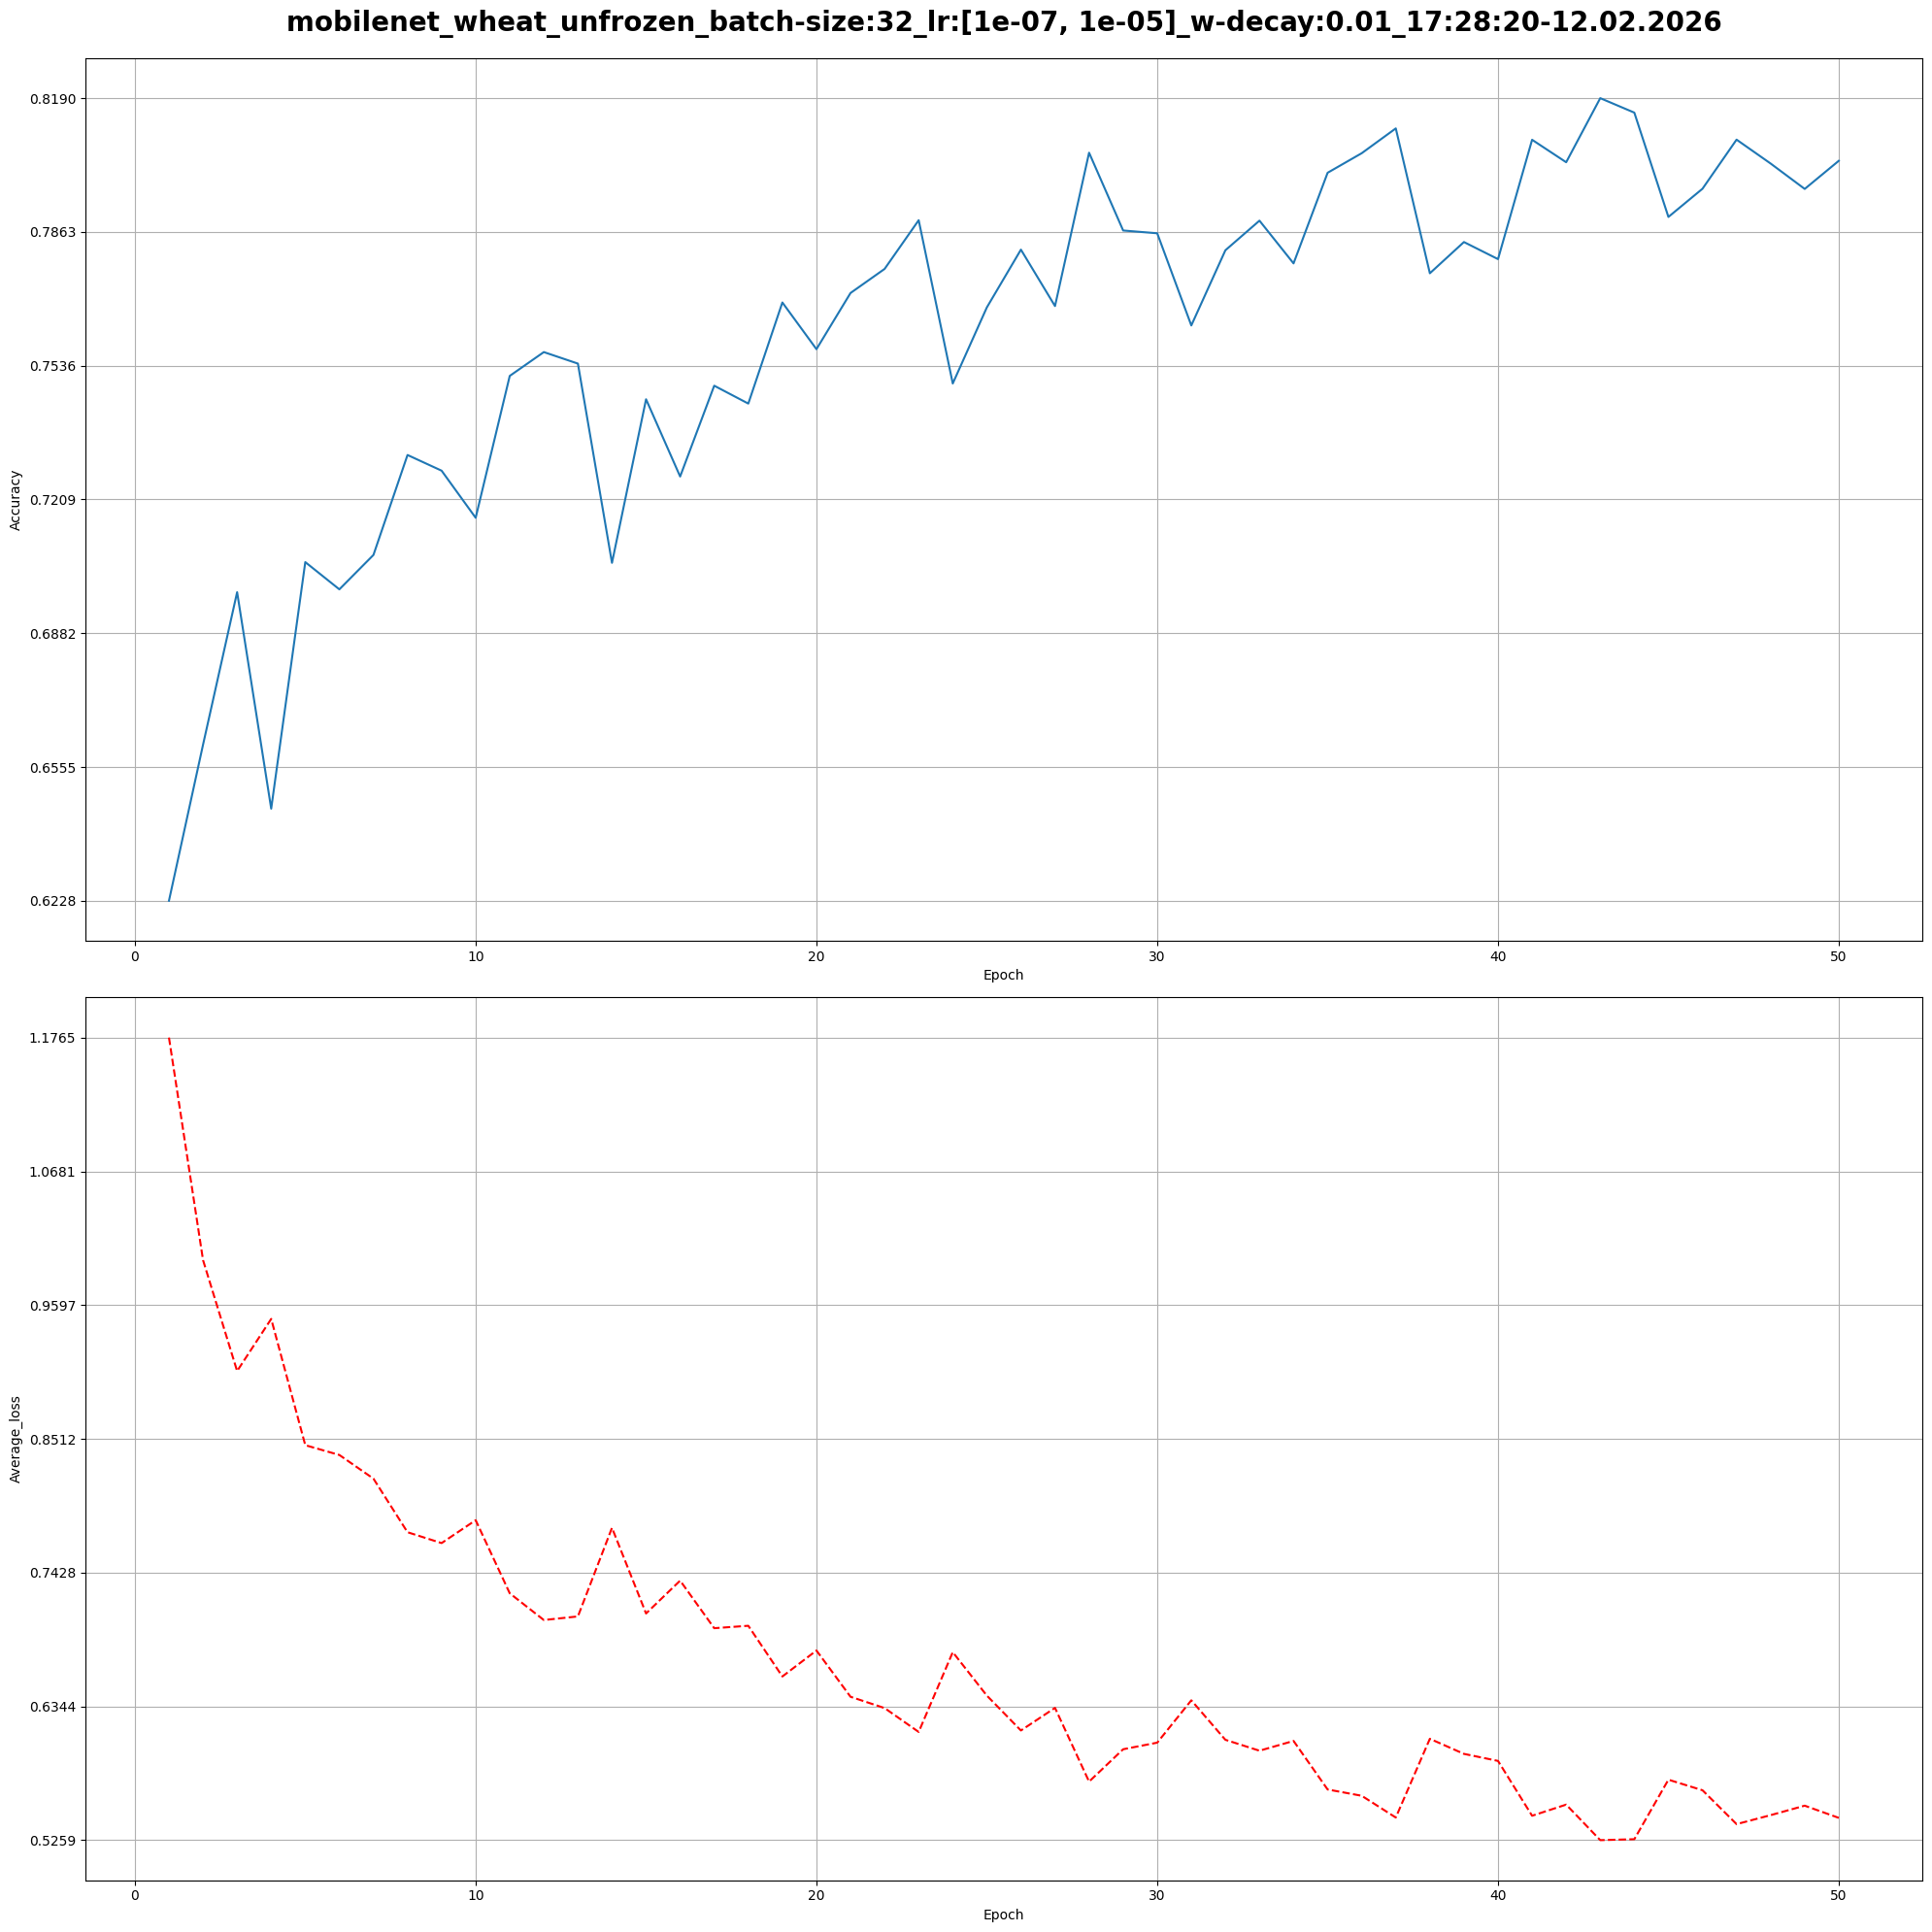

In [21]:
data_folder = "output_data/mobilenet_wheat_unfrozen"
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip(".csv")
    df = pd.read_csv(f)
    plot_dataframe(df, title)

## Confusion Matrices

In [19]:
models_paths = glob.glob('models/*')
cifar_paths = []
wheat_paths = []
for path in models_paths:
    if 'cifar' in path:
        cifar_paths.append(path)
    if 'wheat' in path:
        wheat_paths.append(path)

In [ ]:
from cifar_data_prep import TESTING_DATA as cifar_data, CLASSES as cifar_classes, data_loader as cifar_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_cm_data = []
for path in cifar_paths:
    print(path)
    print(get_batch_size(path))
    test_loader = cifar_loader(cifar_data, device, batch_size=get_batch_size(path))
    cifar_trues, cifar_preds = perform_eval(path,cifar_classes,test_loader)
    cifar_cm_data.append((path, cifar_trues, cifar_preds))
    cifar_title = path.strip("models/").strip(".pth")
    confusion_matrix(cifar_title, cifar_trues, cifar_preds, cifar_classes)

models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-07, 0.001]_w-decay:0.01_15:53:25-16.02.2026.pth
256
Accuracy for class: Black germ is 70.3 %
Accuracy for class: Broken is 92.8 %
Accuracy for class: Fusarium is 71.5 %
Accuracy for class: Insect is 39.6 %
Accuracy for class: Moldy is 37.9 %
Accuracy for class: Sound is 60.6 %
Accuracy for class: Spotted is 48.7 %
Accuracy for class: Sprouted is 70.3 %


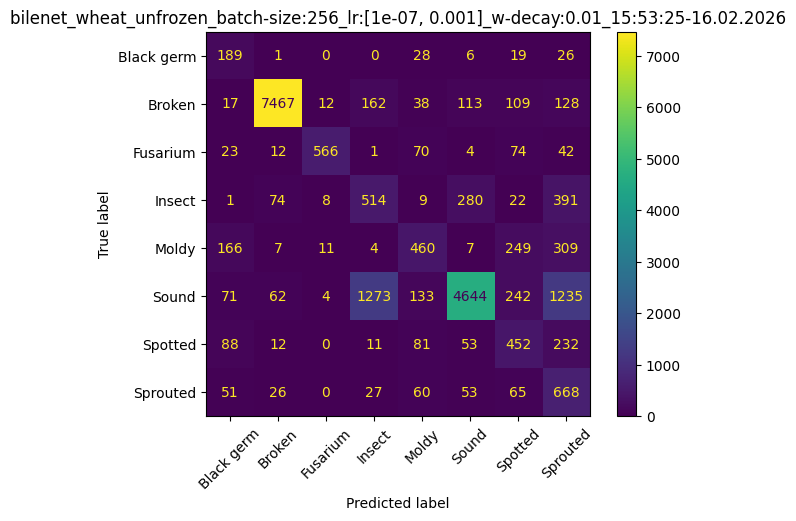

In [20]:
from wheat_data_prep import (
    TESTING_DATA as wheat_data,
    CLASSES as wheat_classes,
    data_loader as wheat_loader,
)

wheat_classes = list(wheat_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wheat_cm_data = []
for path in wheat_paths:
    path = "models/mobilenet_wheat_unfrozen_batch-size:256_lr:[1e-07, 0.001]_w-decay:0.01_15:53:25-16.02.2026.pth"
    print(path)
    print(get_batch_size(path))
    test_loader = wheat_loader(wheat_data, device, batch_size=get_batch_size(path), sampler=None)
    wheat_trues, wheat_preds = perform_eval(path, wheat_classes, test_loader)
    wheat_cm_data.append((path, wheat_trues, wheat_preds))
    wheat_title = path.strip("models/").strip(".pth")
    confusion_matrix(wheat_title, wheat_trues, wheat_preds, wheat_classes)
    break 